# GHIBLI Character generation with GANs
- Vanilla GAN with Keras

## 1) Import Packages

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import imageio

import tensorflow as tf
from keras import layers
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam

## 2) Make Dataset

In [125]:
def load_and_preprocessing(dir):
    data = []
    img_list = os.listdir(dir)
    for name in img_list :
        
        img = Image.open(dir + name)
        img_resize = img.resize((48,48))   
        
        images = tf.keras.preprocessing.image.img_to_array(img_resize)
        images /= 255.  # preprocessing
        
        data.append(images)
        
    return np.stack(data)

In [126]:
dir = "test_img/"
img_list = os.listdir(dir)
img_len = len(os.listdir(dir))

print("The number of images :",img_len)
print(img_list[0:10])

The number of images : 1001
['0000.jpg', '0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg', '0005.jpg', '0006.jpg', '0007.jpg', '0008.jpg', '0009.jpg']


In [127]:
# Make dataset
dataset = load_and_preprocessing(dir)
print("Shape of dataset :", dataset.shape)

Shape of dataset : (1001, 48, 48, 3)


In [128]:
# Random shuffle

s = np.arange(dataset.shape[0])
np.random.shuffle(s)

x_shuffle = dataset[s,:]

print(x_shuffle.shape)

(1001, 48, 48, 3)


## 3) Explore Dataset

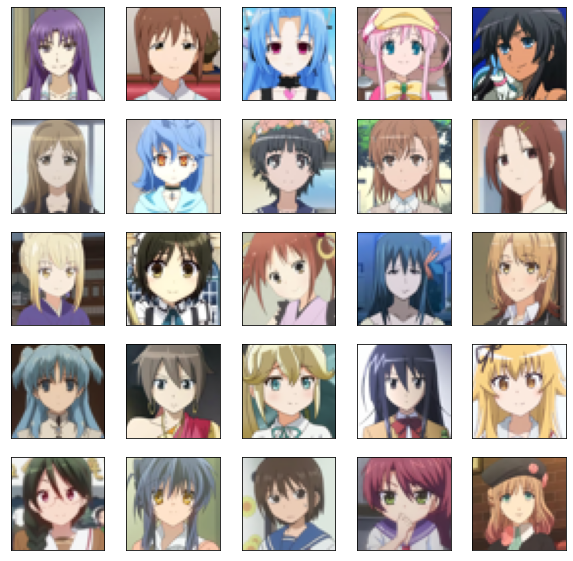

In [146]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = np.reshape(x_shuffle[i,:] , [48,48,3])
    plt.imshow(image)
    plt.savefig("dataset.jpg")
plt.show()

## 4) Generator

In [147]:
# params
latent_dim = 100
height = 48
width = 48
channels = 3

In [148]:
generator_input = layers.Input(shape=(latent_dim,))
g = layers.Dense(128 * 6 * 6)(generator_input)
g = layers.Reshape((6, 6, 128))(g)

g = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(g)
g = layers.BatchNormalization(momentum=0.8)(g)
g = layers.ReLU()(g)

g = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(g)
g = layers.BatchNormalization(momentum=0.8)(g)
g = layers.ReLU()(g)

g = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(g)
g = layers.BatchNormalization(momentum=0.8)(g)
g = layers.ReLU()(g)

g = layers.Conv2D(channels, 3, activation='tanh', padding='same')(g)

generator = Model(generator_input, g)
generator.summary()

Model: "functional_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dense_22 (Dense)             (None, 4608)              465408    
_________________________________________________________________
reshape_17 (Reshape)         (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_transpose_54 (Conv2DT (None, 12, 12, 128)       147584    
_________________________________________________________________
batch_normalization_69 (Batc (None, 12, 12, 128)       512       
_________________________________________________________________
re_lu_54 (ReLU)              (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_transpose_55 (Conv2DT (None, 24, 24, 128)     

## 5) Discriminator

In [149]:
discriminator_input = layers.Input(shape=(height, width, channels))

d = layers.Conv2D(128, 3, strides=2, padding='same')(discriminator_input)
d = layers.LeakyReLU(alpha=0.2)(d)

d = layers.Conv2D(128, 3, strides=2, padding='same')(d)
d = layers.BatchNormalization(momentum=0.8)(d)
d = layers.LeakyReLU(alpha=0.2)(d)

d = layers.Conv2D(64, 3, strides=2, padding='same')(d)
d = layers.BatchNormalization(momentum=0.8)(d)
d = layers.LeakyReLU()(d)

d = layers.Conv2D(64, 3, strides=2, padding='same')(d)
d = layers.BatchNormalization(momentum=0.8)(d)
d = layers.LeakyReLU()(d)

d = layers.Flatten()(d)
d = layers.Dense(1, activation='sigmoid')(d)

discriminator = Model(discriminator_input, d)
discriminator_optimizer = Adam(lr=0.0002, beta_1=0.5, clipvalue=1.0)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
discriminator.summary()

Model: "functional_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 24, 24, 128)       3584      
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 12, 12, 128)       147584    
_________________________________________________________________
batch_normalization_72 (Batc (None, 12, 12, 128)       512       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 6, 6, 64)        

## 6) GANs - Training

In [150]:
gan_input = layers.Input(shape=(latent_dim,))
discriminator.trainable = False

gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

gan_optimizer = Adam(lr=0.0002, beta_1=0.5, clipvalue=1.0)
gan.compile(optimizer = gan_optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])

In [151]:
batch_size = 32

def train(epochs, print_step):
    hist = []
    
    for epoch in range(epochs):
        
        real_images = x_shuffle[np.random.randint(0, x_shuffle.shape[0], batch_size)]
        real_label = np.ones((batch_size, 1))
        
        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
        generated_images = generator.predict(noise)
        fake_label = np.zeros((batch_size, 1))
        
        real_label += 0.05 * np.random.normal(0, 1, size=real_label.shape)
        fake_label += 0.05 * np.random.normal(0, 1, size=fake_label.shape)
        
        # discriminator
        dis_loss_real = discriminator.train_on_batch(real_images, real_label)
        dis_loss_fake = discriminator.train_on_batch(generated_images, fake_label)
        dis_loss = 0.5 * np.add(dis_loss_real, dis_loss_fake)
        
        # Generator
        gene_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        record = (epoch, dis_loss[0], gene_loss[0])
        hist.append(record)

        if epoch % print_step == 0:
            print("%5d iteration - discriminator loss: %.3f, generator loss: %.3f" % record)
            
    return hist

In [152]:
import warnings
warnings.simplefilter("ignore")

In [153]:
%%time
hist_1000 = train(10000, 10)

    0 iteration - discriminator loss: 0.881, generator loss: 0.714
   10 iteration - discriminator loss: 0.070, generator loss: 0.016
   20 iteration - discriminator loss: 0.079, generator loss: 0.117
   30 iteration - discriminator loss: 0.047, generator loss: 0.139
   40 iteration - discriminator loss: -0.079, generator loss: 0.142
   50 iteration - discriminator loss: 0.051, generator loss: 0.134
   60 iteration - discriminator loss: -0.023, generator loss: 0.067
   70 iteration - discriminator loss: -0.016, generator loss: 0.104
   80 iteration - discriminator loss: 0.045, generator loss: 0.083
   90 iteration - discriminator loss: -0.010, generator loss: 0.104
  100 iteration - discriminator loss: -0.028, generator loss: 0.196
  110 iteration - discriminator loss: -0.003, generator loss: 0.120
  120 iteration - discriminator loss: -0.016, generator loss: 0.062
  130 iteration - discriminator loss: -0.039, generator loss: 0.074
  140 iteration - discriminator loss: 0.068, generator

 1220 iteration - discriminator loss: -0.050, generator loss: 0.023
 1230 iteration - discriminator loss: -0.012, generator loss: 0.013
 1240 iteration - discriminator loss: 0.003, generator loss: 0.012
 1250 iteration - discriminator loss: -0.090, generator loss: 0.010
 1260 iteration - discriminator loss: -0.040, generator loss: 0.014
 1270 iteration - discriminator loss: -0.058, generator loss: 0.012
 1280 iteration - discriminator loss: -0.005, generator loss: 0.006
 1290 iteration - discriminator loss: 0.047, generator loss: 0.012
 1300 iteration - discriminator loss: -0.017, generator loss: 0.015
 1310 iteration - discriminator loss: -0.079, generator loss: 0.055
 1320 iteration - discriminator loss: 0.079, generator loss: 0.028
 1330 iteration - discriminator loss: -0.040, generator loss: 0.008
 1340 iteration - discriminator loss: -0.015, generator loss: 0.001
 1350 iteration - discriminator loss: -0.023, generator loss: 0.003
 1360 iteration - discriminator loss: 0.034, genera

 2440 iteration - discriminator loss: 0.005, generator loss: 0.079
 2450 iteration - discriminator loss: -0.013, generator loss: 0.056
 2460 iteration - discriminator loss: 0.067, generator loss: 0.019
 2470 iteration - discriminator loss: -0.098, generator loss: 0.076
 2480 iteration - discriminator loss: -0.058, generator loss: 0.023
 2490 iteration - discriminator loss: 0.069, generator loss: 0.094
 2500 iteration - discriminator loss: -0.060, generator loss: 0.126
 2510 iteration - discriminator loss: 0.084, generator loss: 0.002
 2520 iteration - discriminator loss: 0.041, generator loss: 0.020
 2530 iteration - discriminator loss: -0.022, generator loss: 0.002
 2540 iteration - discriminator loss: -0.036, generator loss: 0.005
 2550 iteration - discriminator loss: 0.017, generator loss: 0.048
 2560 iteration - discriminator loss: -0.012, generator loss: 0.029
 2570 iteration - discriminator loss: 0.009, generator loss: 0.007
 2580 iteration - discriminator loss: 0.026, generator 

 3660 iteration - discriminator loss: -0.029, generator loss: 0.011
 3670 iteration - discriminator loss: 0.005, generator loss: 0.008
 3680 iteration - discriminator loss: 0.039, generator loss: 0.001
 3690 iteration - discriminator loss: -0.032, generator loss: 0.000
 3700 iteration - discriminator loss: -0.105, generator loss: 0.000
 3710 iteration - discriminator loss: -0.011, generator loss: 0.000
 3720 iteration - discriminator loss: -0.117, generator loss: 0.000
 3730 iteration - discriminator loss: -0.094, generator loss: 0.000
 3740 iteration - discriminator loss: 0.017, generator loss: 0.000
 3750 iteration - discriminator loss: 0.005, generator loss: 0.000
 3760 iteration - discriminator loss: -0.099, generator loss: 0.000
 3770 iteration - discriminator loss: -0.162, generator loss: 0.000
 3780 iteration - discriminator loss: -0.103, generator loss: 0.000
 3790 iteration - discriminator loss: -0.130, generator loss: 0.001
 3800 iteration - discriminator loss: 0.039, generat

 4880 iteration - discriminator loss: -0.047, generator loss: 0.000
 4890 iteration - discriminator loss: -0.045, generator loss: 0.000
 4900 iteration - discriminator loss: 0.020, generator loss: 0.000
 4910 iteration - discriminator loss: 0.151, generator loss: 0.000
 4920 iteration - discriminator loss: 0.136, generator loss: 0.000
 4930 iteration - discriminator loss: 0.060, generator loss: 0.000
 4940 iteration - discriminator loss: 0.132, generator loss: 0.000
 4950 iteration - discriminator loss: -0.096, generator loss: 0.000
 4960 iteration - discriminator loss: -0.090, generator loss: 0.000
 4970 iteration - discriminator loss: 0.054, generator loss: 0.000
 4980 iteration - discriminator loss: -0.079, generator loss: 0.000
 4990 iteration - discriminator loss: -0.147, generator loss: 0.000
 5000 iteration - discriminator loss: -0.013, generator loss: 0.005
 5010 iteration - discriminator loss: -0.076, generator loss: 0.000
 5020 iteration - discriminator loss: 0.111, generator

 6100 iteration - discriminator loss: -0.213, generator loss: 0.000
 6110 iteration - discriminator loss: 0.006, generator loss: 0.000
 6120 iteration - discriminator loss: 0.186, generator loss: 0.002
 6130 iteration - discriminator loss: -0.065, generator loss: 0.002
 6140 iteration - discriminator loss: 0.052, generator loss: 0.000
 6150 iteration - discriminator loss: 0.091, generator loss: 0.007
 6160 iteration - discriminator loss: -0.150, generator loss: 0.000
 6170 iteration - discriminator loss: -0.115, generator loss: 0.003
 6180 iteration - discriminator loss: 0.141, generator loss: 0.001
 6190 iteration - discriminator loss: 0.206, generator loss: 0.001
 6200 iteration - discriminator loss: -0.046, generator loss: 0.009
 6210 iteration - discriminator loss: -0.046, generator loss: 0.001
 6220 iteration - discriminator loss: 0.077, generator loss: 0.014
 6230 iteration - discriminator loss: -0.067, generator loss: 0.000
 6240 iteration - discriminator loss: 0.381, generator 

 7320 iteration - discriminator loss: -0.052, generator loss: 0.000
 7330 iteration - discriminator loss: -0.181, generator loss: 0.000
 7340 iteration - discriminator loss: -0.129, generator loss: 0.000
 7350 iteration - discriminator loss: 0.179, generator loss: 0.000
 7360 iteration - discriminator loss: -0.125, generator loss: 0.000
 7370 iteration - discriminator loss: -0.052, generator loss: 0.000
 7380 iteration - discriminator loss: 0.017, generator loss: 0.000
 7390 iteration - discriminator loss: -0.133, generator loss: 0.000
 7400 iteration - discriminator loss: -0.011, generator loss: 0.000
 7410 iteration - discriminator loss: 0.083, generator loss: 0.000
 7420 iteration - discriminator loss: 0.022, generator loss: 0.000
 7430 iteration - discriminator loss: -0.081, generator loss: 0.000
 7440 iteration - discriminator loss: -0.027, generator loss: 0.000
 7450 iteration - discriminator loss: 0.151, generator loss: 0.000
 7460 iteration - discriminator loss: 0.228, generato

 8540 iteration - discriminator loss: 0.020, generator loss: 0.000
 8550 iteration - discriminator loss: 0.031, generator loss: 0.000
 8560 iteration - discriminator loss: 0.115, generator loss: 0.000
 8570 iteration - discriminator loss: -0.128, generator loss: 0.000
 8580 iteration - discriminator loss: -0.153, generator loss: 0.000
 8590 iteration - discriminator loss: 0.079, generator loss: 0.000
 8600 iteration - discriminator loss: -0.060, generator loss: 0.000
 8610 iteration - discriminator loss: 0.046, generator loss: 0.000
 8620 iteration - discriminator loss: -0.019, generator loss: 0.000
 8630 iteration - discriminator loss: -0.018, generator loss: 0.000
 8640 iteration - discriminator loss: -0.061, generator loss: 0.000
 8650 iteration - discriminator loss: 0.015, generator loss: 0.000
 8660 iteration - discriminator loss: 0.040, generator loss: 0.000
 8670 iteration - discriminator loss: 0.001, generator loss: 0.000
 8680 iteration - discriminator loss: -0.021, generator 

 9760 iteration - discriminator loss: -0.019, generator loss: 0.000
 9770 iteration - discriminator loss: 0.058, generator loss: 0.000
 9780 iteration - discriminator loss: -0.014, generator loss: 0.000
 9790 iteration - discriminator loss: 0.107, generator loss: 0.000
 9800 iteration - discriminator loss: -0.002, generator loss: 0.000
 9810 iteration - discriminator loss: 0.085, generator loss: 0.000
 9820 iteration - discriminator loss: 0.037, generator loss: 0.000
 9830 iteration - discriminator loss: 0.158, generator loss: 0.000
 9840 iteration - discriminator loss: 0.031, generator loss: 0.000
 9850 iteration - discriminator loss: -0.003, generator loss: 0.000
 9860 iteration - discriminator loss: 0.059, generator loss: 0.000
 9870 iteration - discriminator loss: 0.134, generator loss: 0.000
 9880 iteration - discriminator loss: 0.082, generator loss: 0.000
 9890 iteration - discriminator loss: -0.056, generator loss: 0.000
 9900 iteration - discriminator loss: 0.001, generator lo

## 7) Save Models

In [154]:
generator.save('tgan_g_10000')
discriminator.save('tgan_d_10000')

INFO:tensorflow:Assets written to: tgan_g_10000\assets
INFO:tensorflow:Assets written to: tgan_d_10000\assets


## 8) Visualization of generated images

In [155]:
def visualization(generated_images, n=4, m=8):
    fig = plt.figure(figsize = (10,10))
    plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)
    
    for i in range(n):
        for j in range(m):
            k = i * m + j
            ax = fig.add_subplot(n, m, i * m + j + 1)
            ax.imshow(generated_images[k][:, :, 0], cmap=plt.cm.bone)
            ax.grid(False)
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
    plt.tight_layout()
    plt.savefig("tresults_10000/plots.jpg")
    plt.show()

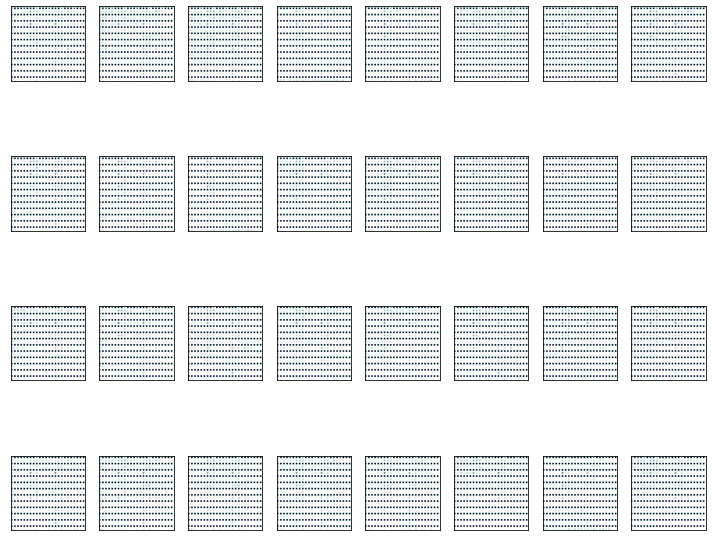

In [161]:
noise_data = np.random.normal(0, 1, size=(100, latent_dim))
visualization(0.5 * generator.predict(noise_data) + 0.5)

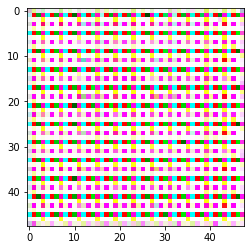

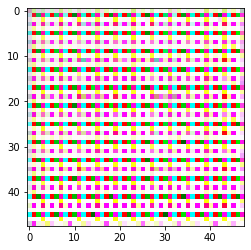

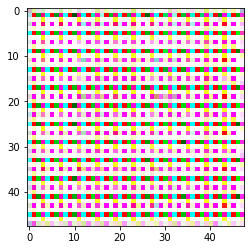

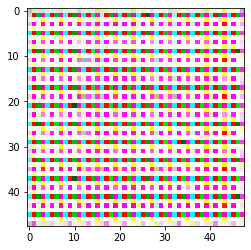

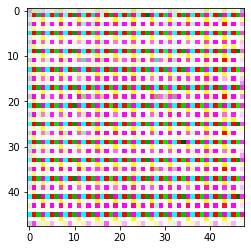

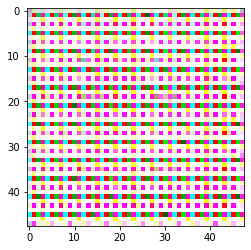

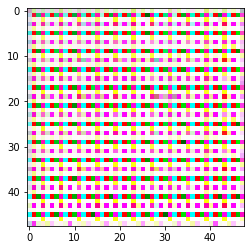

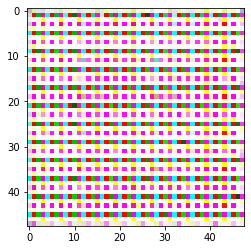

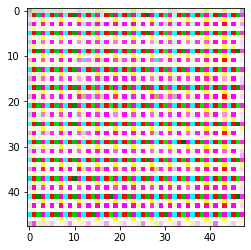

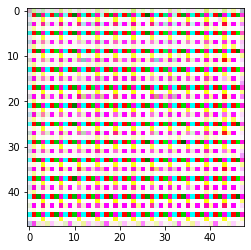

In [157]:
for i in range(10) : 
    noise_data = np.random.normal(0, 1, size=(1, latent_dim))
    pr = generator.predict(noise_data)
    pr = np.reshape(pr, (48, 48, 3))
    plt.imshow(0.5*pr + 0.5, cmap=plt.cm.bone)
    plt.savefig("tresults_10000/" + str(i+1) + ".jpg")
    plt.show()